In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import exp
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
import pandas as pd, numpy as np, re

In [4]:
def bootstrap_mean_ci(x, B=800, alpha=0.05, seed=7):
    rng = np.random.default_rng(seed)
    n = len(x)
    means = np.empty(B)
    for b in range(B):
        idx = rng.integers(0, n, n)
        means[b] = x[idx].mean()
    mu_hat = x.mean()
    lo, hi = np.quantile(means, [alpha/2, 1-alpha/2])
    return mu_hat, lo, hi, means

    
def one_sided_bubble_test(ST, S0=100.0, alpha=0.05, B=800, seed=7):
    rng = np.random.default_rng(seed)
    n = len(ST)
    means = np.empty(B)
    for b in range(B):
        idx = rng.integers(0, n, n)
        means[b] = ST[idx].mean()

    mu_hat = ST.mean()
    U = np.quantile(means, 1 - alpha)  
    m_lower = S0 - U                    
    reject = (m_lower > 0)
    pval = (means >= S0).mean()        

    # CI
    lo2, hi2 = np.quantile(means, [alpha/2, 1 - alpha/2])
    return {
        "E[ST]_hat": mu_hat,
        "m_hat": S0 - mu_hat,
        "m_lower_95": m_lower,          
        "reject_H0": bool(reject),
        "p_value": pval,
        "E[ST]_CI_two_sided": (lo2, hi2),   
        "m_CI_two_sided": (S0 - hi2, S0 - lo2)
    }


def isotonic_increasing(y):
    # classic PAVA (unit weights)
    y = np.asarray(y, float).copy()
    n = len(y)
    lvl = y.copy()
    w = np.ones(n)
    i = 0
    while i < n-1:
        if lvl[i] > lvl[i+1]:
            tot = lvl[i]*w[i] + lvl[i+1]*w[i+1]
            w[i+1] += w[i]
            lvl[i+1] = tot / w[i+1]
            # collapse block
            j = i
            while j > 0 and lvl[j-1] > lvl[j]:
                tot = lvl[j-1]*w[j-1] + lvl[j]*w[j]
                w[j] += w[j-1]
                lvl[j] = tot / w[j]
                j -= 1
            # shift left
            lvl = np.delete(lvl, i)
            w   = np.delete(w, i)
            n -= 1
            i = max(j, 0)
        else:
            i += 1
    return np.repeat(lvl, w.astype(int))

def fit_call_curve_monotone_convex(K, C):
    K = np.asarray(K, float)
    C = np.asarray(C, float)
    idx = np.argsort(K)
    K, C = K[idx], C[idx]
    dK = np.diff(K)
    # initial slopes between points
    s = np.diff(C) / dK
    s_iso = isotonic_increasing(s)
    s_iso = np.minimum(s_iso, 0.0)
    for i in range(len(s_iso)-2, -1, -1):
        if s_iso[i] > s_iso[i+1]:
            s_iso[i] = s_iso[i+1]
    cum = np.concatenate(([0.0], np.cumsum(s_iso * dK)))
    y1 = np.mean(C - cum)
    C_fit = y1 + cum
    # non-negativity (tiny floor), preserve shape
    C_fit = np.maximum(C_fit, 0.0)
    return K, C_fit

def call_prices_from_ST(ST, K_grid):
    ST = np.asarray(ST, float)
    K = np.asarray(K_grid, float)
    C = np.maximum(ST[:, None] - K[None, :], 0.0).mean(axis=0)
    return C

def m_from_call_tail(K, C_fit, tail_frac=0.2):
    n = len(K)
    m = max(1, int(np.ceil(tail_frac * n)))
    return float(C_fit[-m:].mean())


def experiment_rejection_rate(sim_fn, params_list, T, S0=100.0,
                              Npaths=3000, Msteps=400, alpha=0.05,
                              B_boot=200, R=6, seed=1):
    rng = np.random.default_rng(seed)
    rates = []
    for p in params_list:
        rej = 0
        for r in range(R):
            ST = sim_fn(Npaths, Msteps, T, rng, **p)
            out = one_sided_bubble_test(ST, S0=S0, alpha=alpha, B=B_boot, seed=rng.integers(1e9))
            rej += int(out["reject_H0"])
        rates.append(rej / R)
    return np.array(rates)


def sim_bs_paths(N, M, T, rng, sigma=0.20, S0=100.0):
    dt = T / M
    Z = rng.standard_normal((N, M))
    logS = np.full(N, np.log(S0))
    drift = -0.5 * sigma**2 * dt
    diff  = sigma * np.sqrt(dt)
    for k in range(M):
        logS += drift + diff * Z[:, k]
    return np.exp(logS)

def sim_cev_paths(N, M, T, rng, sigma=0.16, beta=1.5, S0=100.0):
    assert beta > 1.0
    dt = T / M
    sdt = np.sqrt(dt)
    Z = rng.standard_normal((N, M))
    a = (beta-1.0)*sigma
    b = 0.5*(beta-1.0)*beta*sigma**2
    Y = np.full(N, S0**(-(beta-1.0)))
    eps = 1e-12
    for k in range(M):
        dW = sdt * Z[:, k]
        Y = Y - a*dW + b*dt/np.maximum(Y, eps)
        Y = np.maximum(Y, eps)
    S = np.power(Y, -1.0/(beta-1.0))
    return np.minimum(S, 1e12)

def sim_sabr_beta1_paths(N, M, T, rng, sigma0=0.25, nu=1.0, rho=0.7, S0=100.0):
    dt = T / M
    sdt = np.sqrt(dt)
    Z2 = rng.standard_normal((N, M))
    sig = np.full(N, sigma0)
    A   = np.zeros(N)
    for k in range(M):
        sig_next = sig * np.exp(-0.5*nu*nu*dt + nu*sdt*Z2[:, k])
        A += 0.5 * (sig*sig + sig_next*sig_next) * dt
        sig = sig_next
    sigma_T = sig
    B = (sigma_T - sigma0)/nu
    Zperp = rng.standard_normal(N)
    J = np.sqrt(np.maximum(A, 0.0)) * Zperp
    logS = rho * B + np.sqrt(max(0.0, 1.0 - rho*rho)) * J - 0.5 * A
    return S0 * np.exp(logS)


def run_once_and_crosscheck(sim_fn, sim_kwargs, T=1.0, S0=100.0,
                            N=3000, M=1500, alpha=0.05, B=600,
                            Kmin=None, Kmax=None, nK=60, seed=1):
    rng = np.random.default_rng(seed)
    ST = sim_fn(N, M, T, rng, **sim_kwargs, S0=S0)
    test = one_sided_bubble_test(ST, S0=S0, alpha=alpha, B=B, seed=seed)
    # call tail route
    if Kmin is None: Kmin = 0.1*S0
    if Kmax is None: Kmax = 3*S0
    K = np.linspace(Kmin, Kmax, nK)
    C = call_prices_from_ST(ST, K)
    Kf, Cf = fit_call_curve_monotone_convex(K, C)
    m_tail = m_from_call_tail(Kf, Cf, tail_frac=0.2)
    return test, (K, C, Kf, Cf, m_tail)


def build_results_df(S0=100.0, T=1.0):
    rows = []
    models = {
        "BS": (sim_bs_paths, dict(sigma=0.2)),
        "CEV":   (sim_cev_paths, dict(beta=1.5, sigma=0.16)),
        "SABR":   (sim_sabr_beta1_paths, dict(sigma0=0.25, nu=2, rho=0.7)),
    }
    for name, (fn, kw) in models.items():
        out, _ = run_once_and_crosscheck(
            fn, kw, T=T, S0=S0, N=30000, M=1500, alpha=0.05, B=600
        )
        lo, hi = out["E[ST]_CI_two_sided"]
        mlo, mhi = out["m_CI_two_sided"]
        rows.append({
            "Model": name,
            "E[S_T] mean": out["E[ST]_hat"],
            "E[S_T] 95% CI low": lo,
            "E[S_T] 95% CI high": hi,
            "m(T)=S0−E[S_T] mean": out["m_hat"],
            "m(T) 95% CI low": mlo,
            "m(T) 95% CI high": mhi,
        })
    return pd.DataFrame(rows)

BS {'E[ST]_hat': 100.16590996896575, 'm_hat': -0.1659099689657495, 'm_lower_95': -0.37372051357327507, 'reject_H0': False, 'p_value': 0.935, 'E[ST]_CI_two_sided': (99.94622218204037, 100.39804404095017), 'm_CI_two_sided': (-0.3980440409501682, 0.05377781795962733)}
CEV {'E[ST]_hat': 54.7143602087099, 'm_hat': 45.2856397912901, 'm_lower_95': 44.08224119767039, 'reject_H0': True, 'p_value': 0.0, 'E[ST]_CI_two_sided': (53.432113419491145, 56.1352573722661), 'm_CI_two_sided': (43.8647426277339, 46.567886580508855)}
SABR {'E[ST]_hat': 93.45855590041148, 'm_hat': 6.541444099588517, 'm_lower_95': 6.1110097772364895, 'reject_H0': True, 'p_value': 0.0, 'E[ST]_CI_two_sided': (92.97204844185744, 93.99556939690936), 'm_CI_two_sided': (6.00443060309064, 7.027951558142561)}
BS Mean-route m_hat: -0.19363382034543974 one-sided LB: -0.39358220693519286 two-sided CI E[ST]: (99.96599707017644, 100.42654413118773) two-sided CI m(T): (-0.4265441311877254, 0.03400292982355779)
BS Tail-route m_tail (from C*)

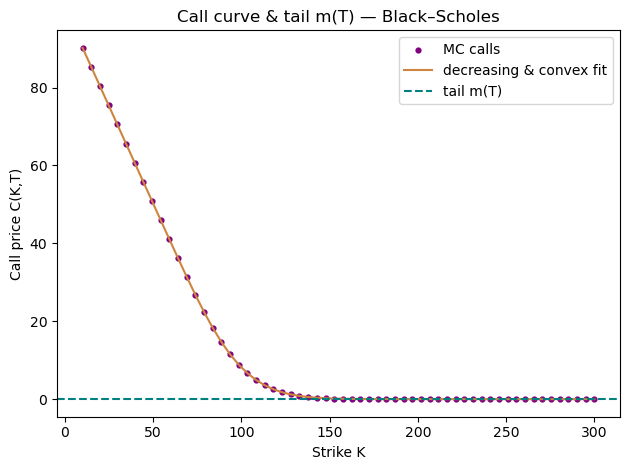

BS m_hat_mean = -0.1936   m_hat_tail(from C_obs) = 0.0000


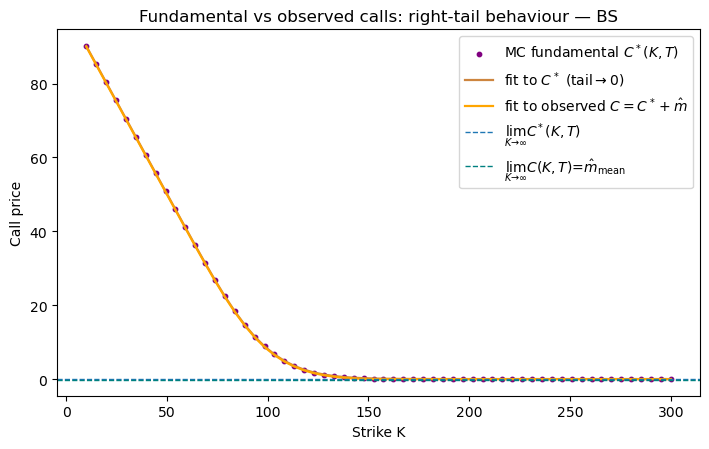

Mean-route m_hat: 6.541444099588517 one-sided LB: 6.1110097772364895 two-sided CI E[ST]: (92.97204844185744, 93.99556939690936) two-sided CI m(T): (6.00443060309064, 7.027951558142561)
Tail-route m_tail (from C*): 1.1464896037226768


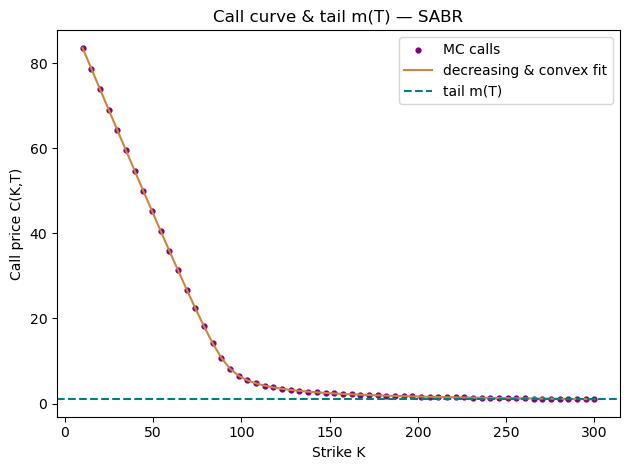

m_hat_mean = 6.5414   m_hat_tail(from C_obs) = 7.6879


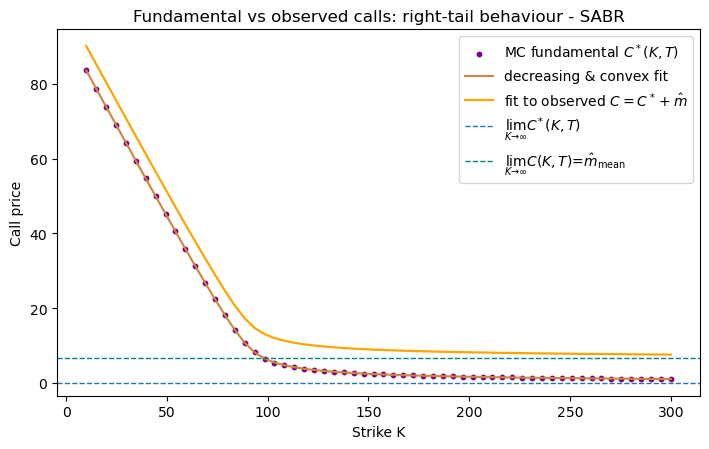

CEV Mean-route m_hat: 45.243765906876675 one-sided LB: 43.72058188943718 two-sided CI E[ST]: (53.07106953508147, 56.74047046498855) two-sided CI m(T): (43.25952953501145, 46.92893046491853)
CEV Tail-route m_tail (from C*): 5.247817425354594


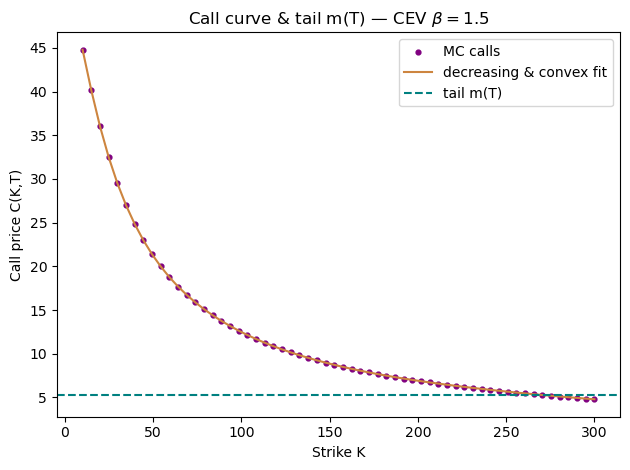

CEV m_hat_mean = 45.2438   m_hat_tail(from C_obs) = 50.4916


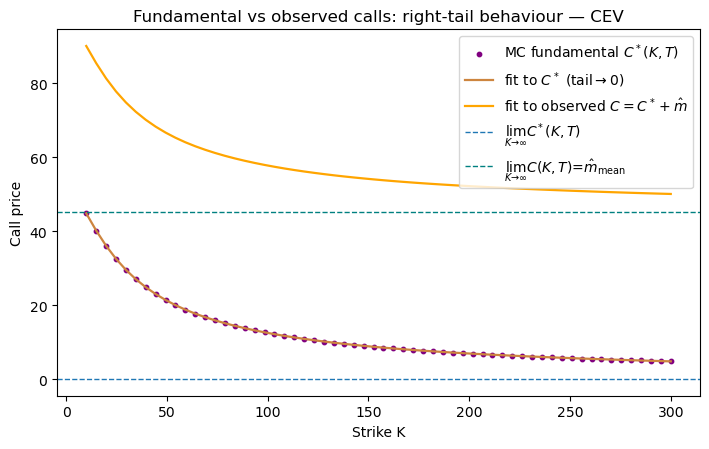

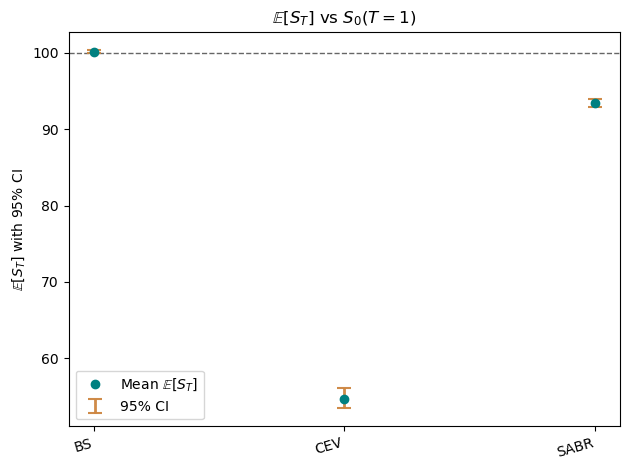

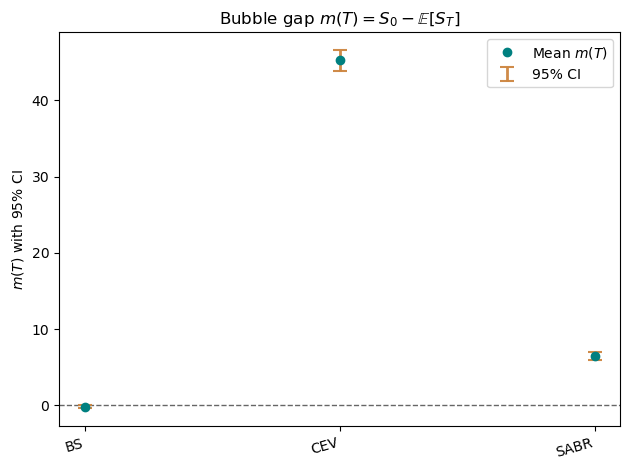

In [5]:
S0, T = 100.0, 1.0
rng = np.random.default_rng(1)
ST_sabr = sim_sabr_beta1_paths(
    N=30000, M=1500, T=1.0, rng=rng,
    sigma0=0.25, nu=2.0, rho=0.7, S0=S0
)
for name, (fn, kw) in {
    "BS":  (sim_bs_paths,  dict(sigma=0.2)),
    "CEV": (sim_cev_paths, dict(beta=1.5, sigma=0.16)),
}.items():
    out, _ = run_once_and_crosscheck(fn, kw, T=1.0, S0=S0, N=30000, M=1500)
    print(name, out)

out_sabr = one_sided_bubble_test(ST_sabr, S0=S0, alpha=0.05, B=600, seed=1)
print("SABR", out_sabr)

### Black–Scholes ###
rng_bs = np.random.default_rng(2)
ST_bs = sim_bs_paths(
    N=30000, M=1500, T=1.0, rng=rng_bs,
    sigma=0.20, S0=S0
)
out_bs = one_sided_bubble_test(ST_bs, S0=S0, alpha=0.05, B=600, seed=2)

K_bs = np.linspace(0.1*S0, 3.0*S0, 60)
C_star_bs = call_prices_from_ST(ST_bs, K_bs)
Kf_star_bs, Cf_star_bs = fit_call_curve_monotone_convex(K_bs, C_star_bs)
m_tail_star_bs = m_from_call_tail(Kf_star_bs, Cf_star_bs, tail_frac=0.2)

print("BS Mean-route m_hat:", out_bs["m_hat"],
      "one-sided LB:", out_bs["m_lower_95"],
      "two-sided CI E[ST]:", out_bs["E[ST]_CI_two_sided"],
      "two-sided CI m(T):", out_bs["m_CI_two_sided"])
print("BS Tail-route m_tail (from C*):", m_tail_star_bs)

plt.figure()
plt.scatter(K_bs, C_star_bs, s=12, label="MC calls", color='purple')
plt.plot(Kf_star_bs, Cf_star_bs, label="decreasing & convex fit", color='peru')
plt.axhline(m_tail_star_bs, linestyle="--", label="tail m(T)", color='teal')
plt.xlabel("Strike K"); plt.ylabel("Call price C(K,T)")
plt.legend(); plt.title("Call curve & tail m(T) — Black–Scholes")
plt.tight_layout(); plt.show()

# Fundamental vs observed tails (same BS run)
m_mean_bs = S0 - ST_bs.mean()
C_obs_bs  = C_star_bs + m_mean_bs
Kf_obs_bs, Cf_obs_bs = fit_call_curve_monotone_convex(K_bs, C_obs_bs)
m_tail_obs_bs = m_from_call_tail(Kf_obs_bs, Cf_obs_bs, tail_frac=0.2)

print(f"BS m_hat_mean = {m_mean_bs:.4f}   m_hat_tail(from C_obs) = {m_tail_obs_bs:.4f}")

plt.figure(figsize=(7.2, 4.6))
plt.scatter(K_bs, C_star_bs, s=10, label=r"MC fundamental $C^*(K,T)$", color='purple')
plt.plot(Kf_star_bs, Cf_star_bs, lw=1.6, label=r"fit to $C^*$ (tail$\to 0$)",color='peru')
plt.plot(Kf_obs_bs,  Cf_obs_bs,  lw=1.6, label=r"fit to observed $C=C^*+\hat m$", color='orange')
plt.axhline(0.0,     ls="--", lw=1, label=r"$\lim_{K\to\infty} C^*(K,T)$")
plt.axhline(m_mean_bs, ls="--", lw=1, label=r"$\lim_{K\to\infty} C(K,T)=\hat m_{\text{mean}}$", color='teal')
plt.xlabel("Strike K"); plt.ylabel("Call price")
plt.title("Fundamental vs observed calls: right-tail behaviour — BS")
plt.legend(); plt.tight_layout(); plt.show()

K = np.linspace(0.1*S0, 3.0*S0, 60)
C_star = call_prices_from_ST(ST_sabr, K)          # fundamental calls
Kf_star, Cf_star = fit_call_curve_monotone_convex(K, C_star)
m_tail_star = m_from_call_tail(Kf_star, Cf_star, tail_frac=0.2)

print("Mean-route m_hat:", out_sabr["m_hat"],
      "one-sided LB:", out_sabr["m_lower_95"],
      "two-sided CI E[ST]:", out_sabr["E[ST]_CI_two_sided"],
      "two-sided CI m(T):", out_sabr["m_CI_two_sided"])
print("Tail-route m_tail (from C*):", m_tail_star)

plt.figure()
plt.scatter(K, C_star, s=12, label="MC calls", color='purple')
plt.plot(Kf_star, Cf_star, label="decreasing & convex fit", color='peru')
plt.axhline(m_tail_star, linestyle="--", label="tail m(T)", color='teal')
plt.xlabel("Strike K"); plt.ylabel("Call price C(K,T)")
plt.legend(); plt.title("Call curve & tail m(T) — SABR")
plt.tight_layout(); plt.show()

m_mean = S0 - ST_sabr.mean()
C_obs  = C_star + m_mean
Kf_obs, Cf_obs = fit_call_curve_monotone_convex(K, C_obs)
m_tail_obs = m_from_call_tail(Kf_obs, Cf_obs, tail_frac=0.2)

print(f"m_hat_mean = {m_mean:.4f}   m_hat_tail(from C_obs) = {m_tail_obs:.4f}")
plt.figure(figsize=(7.2, 4.6))
plt.scatter(K, C_star, s=10, label=r"MC fundamental $C^*(K,T)$", color='purple')
plt.plot(Kf_star, Cf_star, label="decreasing & convex fit", color='peru')
plt.plot(Kf_obs,  Cf_obs,  lw=1.6, label=r"fit to observed $C=C^*+\hat m$", color='orange')
plt.axhline(0.0,    ls="--", lw=1, label=r"$\lim_{K\to\infty} C^*(K,T)$")
plt.axhline(m_mean, ls="--", lw=1, label=r"$\lim_{K\to\infty} C(K,T)=\hat m_{\text{mean}}$", color='teal')
plt.xlabel("Strike K"); plt.ylabel("Call price")
plt.title("Fundamental vs observed calls: right-tail behaviour - SABR")
plt.legend(); plt.tight_layout(); plt.show()

rng_cev = np.random.default_rng(3)
ST_cev = sim_cev_paths(
    N=30000, M=1500, T=1.0, rng=rng_cev,
    sigma=0.16, beta=1.5, S0=S0
)

out_cev = one_sided_bubble_test(ST_cev, S0=S0, alpha=0.05, B=600, seed=3)
K_cev = np.linspace(0.1*S0, 3.0*S0, 60)
C_star_cev = call_prices_from_ST(ST_cev, K_cev)
Kf_star_cev, Cf_star_cev = fit_call_curve_monotone_convex(K_cev, C_star_cev)
m_tail_star_cev = m_from_call_tail(Kf_star_cev, Cf_star_cev, tail_frac=0.2)

print("CEV Mean-route m_hat:", out_cev["m_hat"],
      "one-sided LB:", out_cev["m_lower_95"],
      "two-sided CI E[ST]:", out_cev["E[ST]_CI_two_sided"],
      "two-sided CI m(T):", out_cev["m_CI_two_sided"])
print("CEV Tail-route m_tail (from C*):", m_tail_star_cev)

plt.figure()
plt.scatter(K_cev, C_star_cev, s=12, label="MC calls", color='purple')
plt.plot(Kf_star_cev, Cf_star_cev, label="decreasing & convex fit", color='peru')
plt.axhline(m_tail_star_cev, linestyle="--", label="tail m(T)", color='teal')
plt.xlabel("Strike K"); plt.ylabel("Call price C(K,T)")
plt.legend(); plt.title(r"Call curve & tail m(T) — CEV $\beta=1.5$")
plt.tight_layout(); plt.show()

m_mean_cev = S0 - ST_cev.mean()
C_obs_cev  = C_star_cev + m_mean_cev
Kf_obs_cev, Cf_obs_cev = fit_call_curve_monotone_convex(K_cev, C_obs_cev)
m_tail_obs_cev = m_from_call_tail(Kf_obs_cev, Cf_obs_cev, tail_frac=0.2)

print(f"CEV m_hat_mean = {m_mean_cev:.4f}   m_hat_tail(from C_obs) = {m_tail_obs_cev:.4f}")

plt.figure(figsize=(7.2, 4.6))
plt.scatter(K_cev, C_star_cev, s=10, label=r"MC fundamental $C^*(K,T)$",color='purple')
plt.plot(Kf_star_cev, Cf_star_cev, lw=1.6, label=r"fit to $C^*$ (tail$\to 0$)",color='peru')
plt.plot(Kf_obs_cev,  Cf_obs_cev,  lw=1.6, label=r"fit to observed $C=C^*+\hat m$",color='orange')
plt.axhline(0.0,       ls="--", lw=1, label=r"$\lim_{K\to\infty} C^*(K,T)$")
plt.axhline(m_mean_cev, ls="--", lw=1, label=r"$\lim_{K\to\infty} C(K,T)=\hat m_{\text{mean}}$",color='teal')
plt.xlabel("Strike K"); plt.ylabel("Call price")
plt.title(r"Fundamental vs observed calls: right-tail behaviour — CEV")
plt.legend(); plt.tight_layout(); plt.show()


df = build_results_df(S0=S0, T=T)
x = np.arange(len(df))
means = df["E[S_T] mean"].to_numpy()
lo = df["E[S_T] 95% CI low"].to_numpy()
hi = df["E[S_T] 95% CI high"].to_numpy()
yerr = np.vstack((means - lo, hi - means))
m_vals = df["m(T)=S0−E[S_T] mean"].to_numpy()
mlo = df["m(T) 95% CI low"].to_numpy()
mhi = df["m(T) 95% CI high"].to_numpy()
yerr_m = np.vstack((m_vals - mlo, mhi - m_vals))

fig, ax = plt.subplots()
ax.plot(x, means, 'o', label=r'Mean $\mathbb{E}[S_T]$', color='teal', markersize=6, zorder=3)

eb = ax.errorbar(x, means, yerr=yerr, fmt='none',
                 ecolor='peru', elinewidth=2, capsize=5, capthick=1.5, alpha=0.95,
                 label='95% CI', zorder=1)

ax.axhline(S0, linestyle='--', color='0.4', linewidth=1, zorder=0)
ax.set_xticks(x, df["Model"].values)
plt.setp(ax.get_xticklabels(), rotation=16, ha='right')
ax.set_ylabel(r"$\mathbb{E}[S_T]$ with 95% CI")
ax.set_title(r"$\mathbb{E}[S_T]$ vs $S_0 (T=1)$")
ax.legend()
fig.tight_layout()
plt.show()


fig, ax = plt.subplots()
ax.plot(x, m_vals, 'o', label=r'Mean $m(T)$', color='teal', markersize=6, zorder=3)


eb = ax.errorbar(x, m_vals, yerr=yerr_m, fmt='none',
                 ecolor='peru', elinewidth=2, capsize=5, capthick=1.5, alpha=0.95,
                 label='95% CI', zorder=1)

ax.axhline(0.0, linestyle='--', color='0.4', linewidth=1, zorder=0)
ax.set_xticks(x, df["Model"].values)
plt.setp(ax.get_xticklabels(), rotation=16, ha='right')
ax.set_ylabel(r"$m(T)$ with 95% CI")
ax.set_title(r"Bubble gap $m(T) = S_0 − \mathbb{E}[S_T]$")
ax.legend()
fig.tight_layout()
plt.show()

E_Q[S_T]_hat = 53.855,   m_hat = 46.145 (S0 - E_hat)


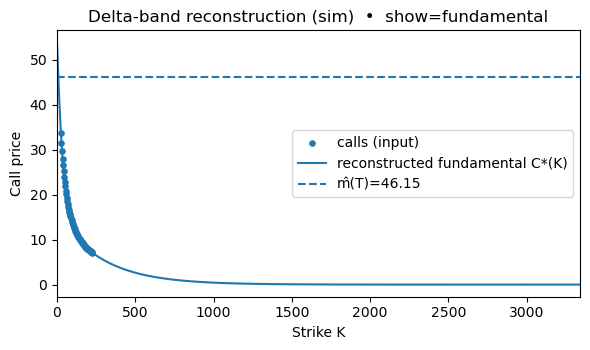

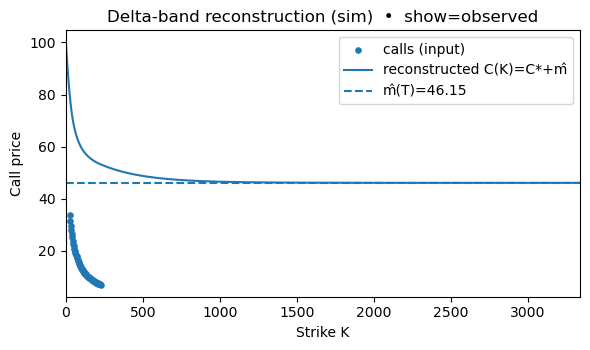

In [6]:
def _N(x):
    x = np.asarray(x)
    return 0.5*(1.0 + np.vectorize(math.erf)(x/np.sqrt(2.0)))

def bs_call_delta(S0, K, T, r, d, sigma):
    if T <= 0 or sigma <= 0:
        return float(np.exp(-d*T) * (1.0 if S0>K else (0.0 if S0<K else 0.5)))
    srt = sigma*np.sqrt(T)
    d1 = (np.log(S0/K) + (r - d + 0.5*sigma*sigma)*T)/srt
    return float(np.exp(-d*T)*_N(d1))

def implied_vol_call(price, S0, K, T, r, d, tol=1e-8, maxit=120):
    def _bs_price(S0, K, T, r, d, sigma):
        if T <= 0 or sigma <= 0: return float(max(S0 - K, 0.0))
        srt = sigma*np.sqrt(T)
        d1 = (np.log(S0/K) + (r - d + 0.5*sigma*sigma)*T)/srt
        d2 = d1 - srt
        return float(S0*np.exp(-d*T)*_N(d1) - K*np.exp(-r*T)*_N(d2))
    intrinsic = max(S0 - K, 0.0)
    p = min(max(price, intrinsic), S0)
    lo, hi = 1e-8, 5.0
    f_lo = _bs_price(S0, K, T, r, d, lo) - p
    f_hi = _bs_price(S0, K, T, r, d, hi) - p
    if f_lo*f_hi <= 0:
        for _ in range(maxit):
            mid = 0.5*(lo+hi)
            f_mid = _bs_price(S0, K, T, r, d, mid) - p
            if abs(f_mid) < tol or (hi-lo) < 1e-8: return max(mid, 1e-8)
            if f_lo*f_mid <= 0: hi, f_hi = mid, f_mid
            else:               lo, f_lo = mid, f_mid
    sigma = 0.4
    for _ in range(maxit):
        diff = _bs_price(S0, K, T, r, d, sigma) - p
        if abs(diff) < tol: return max(sigma, 1e-8)
        h = 1e-4
        up = _bs_price(S0, K, T, r, d, sigma+h)
        dn = _bs_price(S0, K, T, r, d, sigma-h)
        vega = (up - dn)/(2*h)
        if vega <= 1e-10: break
        sigma = max(1e-8, sigma - diff/vega)
    return max(sigma, 1e-8)
    
def monotone_decreasing_projection(q):
    q = np.clip(np.asarray(q,float), 0.0, 1.0)
    out = np.empty_like(q); m = 1.0
    for i, val in enumerate(q):
        m = min(m, val); out[i] = m
    return out

def isotonic_increasing(y):
    y = np.asarray(y, float).copy(); n = len(y)
    lvl = y.copy(); w = np.ones(n); i = 0
    while i < n-1:
        if lvl[i] > lvl[i+1]:
            tot = lvl[i]*w[i] + lvl[i+1]*w[i+1]
            w[i+1] += w[i]; lvl[i+1] = tot / w[i+1]
            j = i
            while j > 0 and lvl[j-1] > lvl[j]:
                tot = lvl[j-1]*w[j-1] + lvl[j]*w[j]
                w[j] += w[j-1]; lvl[j] = tot / w[j]; j -= 1
            lvl = np.delete(lvl, i); w = np.delete(w, i); n -= 1; i = max(j, 0)
        else:
            i += 1
    return np.repeat(lvl, w.astype(int))

def convex_decreasing_fit_on_band(K, C):
    K = np.asarray(K, float); C = np.asarray(C, float)
    idx = np.argsort(K); K, C = K[idx], C[idx]
    dK = np.diff(K); s = np.diff(C)/dK
    s_iso = isotonic_increasing(s)
    s_iso = np.minimum(s_iso, 0.0)
    for i in range(len(s_iso)-2, -1, -1):
        s_iso[i] = min(s_iso[i], s_iso[i+1])
    cum = np.concatenate(([0.0], np.cumsum(s_iso*dK)))
    y1  = np.mean(C - cum)
    C_fit = np.maximum(y1 + cum, 0.0)
    dC = np.empty_like(C_fit)
    dC[0]  = (C_fit[1]-C_fit[0])/(K[1]-K[0])
    dC[-1] = (C_fit[-1]-C_fit[-2])/(K[-1]-K[-2])
    dC[1:-1] = (C_fit[2:]-C_fit[:-2])/(K[2:]-K[:-2])
    return K, C_fit, dC

### delta-band estimator ###
def delta_band_from_calls(K, C, S0, T, r=0.0, d=0.0,
                          band=(0.45,0.55), left_mode="linear", left_alpha=None):
    K = np.asarray(K, float); C = np.asarray(C, float)
    Ctilde = C * np.exp(r*T); F0T = S0 * np.exp((r - d)*T)

    # use BS delta to pick the band (need an IV guess per strike)
    ivs  = [implied_vol_call(c, S0, k, T, r, d) for k,c in zip(K,C)]
    dels = [bs_call_delta(S0, k, T, r, d, s)   for k,s in zip(K,ivs)]
    ivs, dels = np.array(ivs), np.array(dels)
    msk = (dels >= band[0]) & (dels <= band[1])
    if msk.sum() < 3: raise ValueError("Not enough quotes in chosen delta band")
    Kb, Cb = K[msk], Ctilde[msk]

    K_mid, C_fit_mid, dC_mid = convex_decreasing_fit_on_band(Kb, Cb)
    q_mid = monotone_decreasing_projection(-dC_mid)

    ### left wing ###
    K0, q0 = K_mid[0], float(np.clip(q_mid[0], 0.0, 1.0))
    if left_alpha is not None:
        gamma = left_alpha/(1.0-left_alpha) if left_alpha < 1 else 1e6
        K_left = np.linspace(0.0, K0, 256)
        q_left = 1.0 - (1.0-q0)*(K_left/K0)**gamma
        E_left = float(np.trapz(q_left, K_left))
    else:
        if left_mode == "min":
            K_left = np.linspace(0.0, K0, 64); q_left = np.full_like(K_left, q0); E_left = K0*q0
        elif left_mode == "max":
            K_left = np.linspace(0.0, K0, 64); q_left = np.ones_like(K_left);     E_left = K0
        else:
            K_left = np.linspace(0.0, K0, 64); q_left = np.linspace(1.0, q0, 64); E_left = 0.5*(1+q0)*K0

    ### right wing ###
    KN, CN = K_mid[-1], float(C_fit_mid[-1])
    qN = max(min(q_mid[-1], 1.0), 1e-8)
    lam = qN / max(CN, 1e-12)
    K_right = np.linspace(KN, KN + 20.0/lam, 256)
    q_right = qN * np.exp(-lam*(K_right-KN))
    E_mid   = float(np.trapz(q_mid, K_mid))
    E_right = float(CN)  # exact integral under our match
    E_hat   = float(E_left + E_mid + E_right)
    m_hat   = float(F0T - E_hat)

    ### reconstruct C* and C*+m for plotting ###
    K_all  = np.concatenate([K_left[:-1], K_mid, K_right])
    q_all  = np.concatenate([q_left[:-1], q_mid, q_right])
    idx = np.argsort(K_all); K_all, q_all = K_all[idx], q_all[idx]
    tail = np.zeros_like(K_all); acc=0.0
    for i in range(len(K_all)-2, -1, -1):
        dK = K_all[i+1] - K_all[i]
        acc += 0.5*(q_all[i] + q_all[i+1])*dK
        tail[i] = acc
    Cstar = tail
    if K_all[0] > 0: K_all = np.insert(K_all, 0, 0.0); Cstar = np.insert(Cstar, 0, E_hat)
    Cobs = Cstar + m_hat
    return {"F0T":F0T, "E_hat":E_hat, "m_hat":m_hat, "K":K, "C":C,
            "curves":{"K_all":K_all, "Cstar":Cstar, "Cobs":Cobs}}



def plot_call_and_tail_delta_band(est, show="fundamental", title="Delta-band reconstruction"):
    K, C = est["K"], est["C"]
    K_all  = est["curves"]["K_all"]
    Cstar  = est["curves"]["Cstar"]        
    m_hat  = est["m_hat"]
    
    if show == "observed":
        yline = Cstar + m_hat              
        label = "reconstructed C(K)=C*+m̂"
    else:  
        yline = Cstar
        label = "reconstructed fundamental C*(K)"
        

    j = np.argmax(Cstar < 1e-4) if np.any(Cstar < 1e-4) else len(Cstar)-1
    xmax = K_all[max(10, j)]
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3.6))
    plt.scatter(K, C, s=14, label="calls (input)")
    plt.plot(K_all, yline, label=label)
    plt.axhline(m_hat, ls="--", label=f"m̂(T)={m_hat:.2f}")
    plt.xlim(0, xmax)
    plt.xlabel("Strike K"); plt.ylabel("Call price")
    plt.title(title + f"  •  show={show}")
    plt.legend(); plt.tight_layout(); plt.show()


###  simulate ST (CEV bubble), then use the estimator ###
def sim_cev_paths(N, M, T, rng, sigma=0.16, beta=1.5, S0=100.0):
    assert beta > 1.0
    dt = T / M; sdt = np.sqrt(dt)
    Z = rng.standard_normal((N, M))
    a = (beta-1.0)*sigma
    b = 0.5*(beta-1.0)*beta*sigma**2
    Y = np.full(N, S0**(-(beta-1.0)))
    eps = 1e-12
    for k in range(M):
        dW = sdt * Z[:, k]
        Y = Y - a*dW + b*dt/np.maximum(Y, eps)
        Y = np.maximum(Y, eps)
    S = np.power(Y, -1.0/(beta-1.0))
    return np.minimum(S, 1e12)

### define params ###
S0, T = 100.0, 1.0
rng = np.random.default_rng(2)

### model ###
ST = sim_cev_paths(N=30000, M=1500, T=T, rng=rng, sigma=0.16, beta=1.5, S0=S0)

### price calls on a grid from the MC ST r=d=0 ###
K = np.linspace(25, 225, 60)
C = np.maximum(ST[:,None] - K[None,:], 0.0).mean(axis=0)

### run delta-band estimator  ###
est = delta_band_from_calls(K, C, S0=S0, T=T, r=0.0, d=0.0,
                            band=(0.2,8), left_mode="linear")

### plot ###
print(f"E_Q[S_T]_hat = {est['E_hat']:.3f},   m_hat = {est['m_hat']:.3f} (S0 - E_hat)")
plot_call_and_tail_delta_band(est, title="Delta-band reconstruction (sim)")
plot_call_and_tail_delta_band(est, show="observed", title="Delta-band reconstruction (sim)")

E_Q[S_T]_hat = 53.855,   m_hat = 46.145 (S0 - E_hat in r=d=0 world)


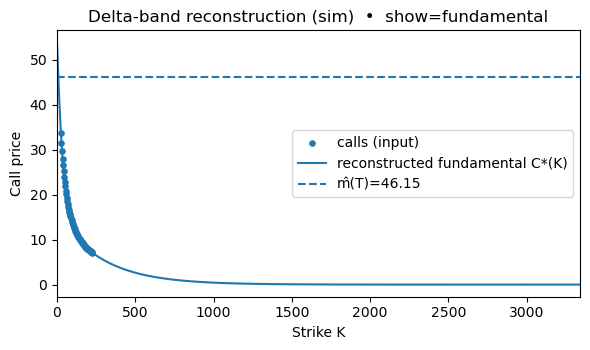

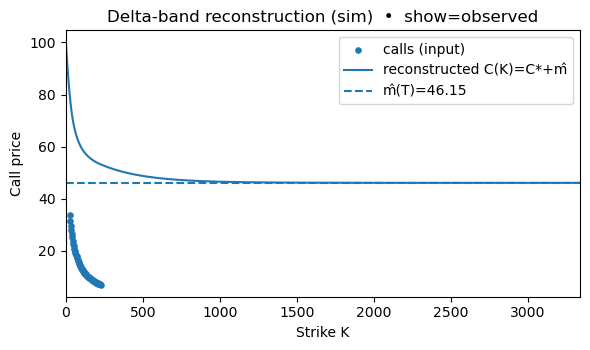

In [7]:
S0, T = 100.0, 1.0
rng = np.random.default_rng(2)
ST = sim_cev_paths(N=30000, M=1500, T=T, rng=rng, sigma=0.16, beta=1.5, S0=S0)
K = np.linspace(25, 225, 60)
C = np.maximum(ST[:,None] - K[None,:], 0.0).mean(axis=0)
est = delta_band_from_calls(K, C, S0=S0, T=T, r=0.0, d=0.0,
                            band=(0,1), left_mode="linear")

print(f"E_Q[S_T]_hat = {est['E_hat']:.3f},   m_hat = {est['m_hat']:.3f} (S0 - E_hat in r=d=0 world)")
plot_call_and_tail_delta_band(est, title="Delta-band reconstruction (sim)")
plot_call_and_tail_delta_band(est, show="observed",
                              title="Delta-band reconstruction (sim)")

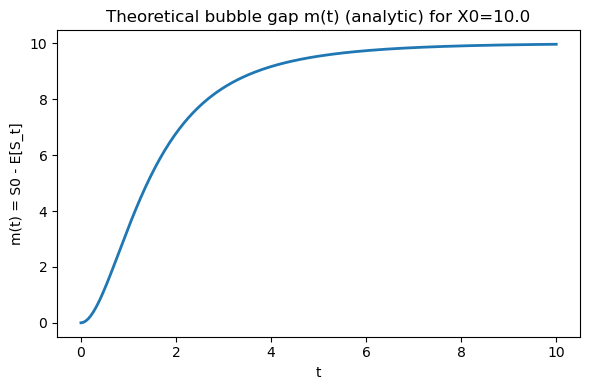

,t,S0,E[S_t] (analytic),m(t) (analytic)
0,0.25,10.0,9.641778,0.358222
1,0.50,10.0,8.782239,1.217761
2,1.00,10.0,6.588680,3.411320
3,2.00,10.0,3.219653,6.780347
4,3.00,10.0,1.587524,8.412476
5,4.00,10.0,0.831473,9.168527
6,10.00,10.0,0.032729,9.967271


In [8]:
### Analytic m(t) curve and small summary table ###
def m_true_fn(t, x0):
    return math.exp(x0) - math.exp(x0 * (2.0*math.exp(-t/2.0) - math.exp(-t)))

s0 = 10.0
ts = np.linspace(0.0, 10.0, 200)
X0 = np.log(1+s0)
E_St = np.array([s0 - m for m in m_vals])
m_vals = np.array([m_true_fn(t, X0) for t in ts])
# Plot m(t)
plt.figure(figsize=(6,4))
plt.plot(ts, m_vals, linewidth=2)
plt.xlabel("t")
plt.ylabel("m(t) = S0 - E[S_t]")
plt.title("Theoretical bubble gap m(t) (analytic) for X0=10.0")
plt.tight_layout()
plt.show()

sample_ts = [0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 10.0]
rows = []
for t in sample_ts:
    m = m_true_fn(t, X0)
    rows.append({
        "t": t,
        "S0": s0,
        "E[S_t] (analytic)": s0 - m,
        "m(t) (analytic)": m
    })
df = pd.DataFrame(rows)
df

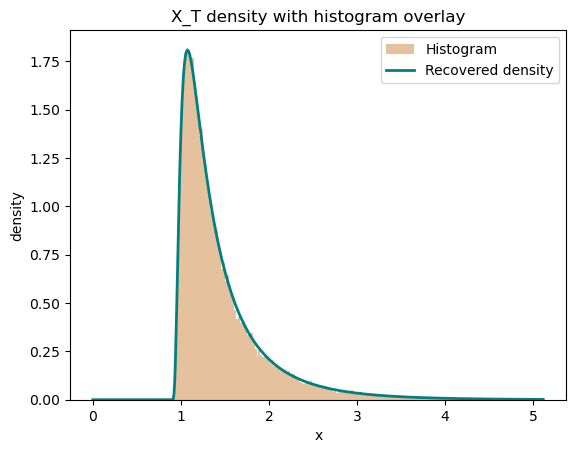

Checks int f_X dx ≈ 1.000000


In [9]:
S0 = 10.0
T  = 1.0
N_terms = 2048
L_trunc = 24.0
a_pad   = 0

def mgf_X(u, t, X0):
    u = np.asarray(u, dtype=np.complex128)
    w = 1.0 - np.sqrt(1.0 - u)
    return np.exp(X0 * (1.0 - (w * np.exp(-t/2.0) - 1.0)**2))

def cf_X(omega, t, X0):
    return mgf_X(1j*omega, t, X0)

def cumulants(t, X0, h=1e-6):
    K = lambda z: np.log(mgf_X(z, t, X0)).real
    c1 = (K(h) - K(-h)) / (2*h)
    c2 = (K(h) - 2*K(0.0) + K(-h)) / (h*h)
    return c1, max(c2, 1e-18)

 ###  COS density ###
def cos_pdf_X_density(t, X0, N=N_terms, L=L_trunc, a_pad=a_pad, fejer=True):
    c1, c2 = cumulants(t, X0)
    a = -abs(a_pad)                 
    b = c1 + L * np.sqrt(c2)        
    k = np.arange(N)
    u = k * np.pi / (b - a)
    phi = cf_X(u, t, X0) * np.exp(-1j * u * a)
    Ak  = (2.0 / (b - a)) * np.real(phi)
    Ak[0] *= 0.5
    if fejer:
        Ak *= (1.0 - k / N)
    x  = np.linspace(a, b, N)
    fx = np.cos(np.outer(x - a, u)) @ Ak
    keep = x >= 0.0
    x = x[keep]
    fx = np.maximum(fx[keep], 0.0)
    mass = np.trapz(fx, x)
    if mass > 0:
        fx /= mass
    return x, fx

def sample_from_pdf_grid(x, f, n, seed=0):
    rng = np.random.default_rng(seed)
    f = np.maximum(f, 0.0)
    cdf = np.cumsum((f[:-1] + f[1:]) / 2.0 * np.diff(x))
    cdf = np.concatenate([[0.0], cdf])
    cdf /= cdf[-1]
    u = rng.random(n)
    return np.interp(u, cdf, x)

X0 = np.log1p(S0)
x, fX = cos_pdf_X_density(T, X0, N=N_terms, L=L_trunc, a_pad=a_pad, fejer=False)
mass_X = np.trapz(fX, x)
X_samples = sample_from_pdf_grid(x, fX, n=50000, seed=2026)
counts, bin_edges = np.histogram(X_samples, bins=200, density=False)
area_hist = float(np.sum(counts * np.diff(bin_edges)))
x_q = float(np.quantile(X_samples, 0.999))
mask = x <= x_q

plt.figure()
plt.hist(X_samples[X_samples <= x_q], bins=200, density=True, alpha=0.5, label="Histogram", color='peru')
plt.plot(x[mask], fX[mask], linewidth=2, label="Recovered density", color='teal')
plt.title(f"X_T density with histogram overlay")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.show()

print(f"Checks int f_X dx ≈ {mass_X:.6f}")

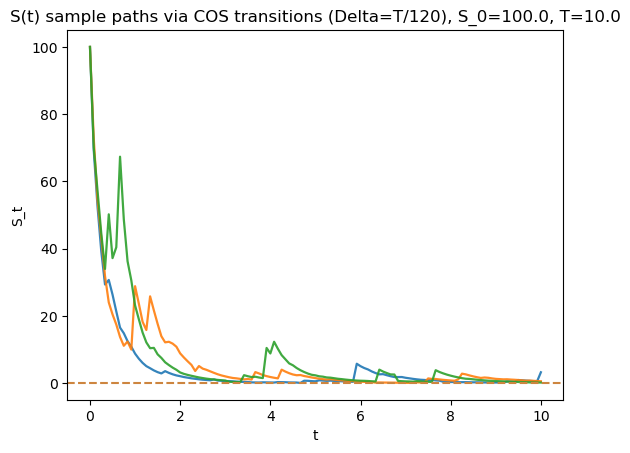

From 3 paths: mean(S_T)=1.326000


In [10]:
### Parameters ###
S0 = 100.0
T  = 10.0
n_steps = 120
n_paths = 3         
N_terms = 2048       
L_trunc = 20.0     
seed    = 2027



def mgf_X(u, t, X0):
    u = np.asarray(u, dtype=np.complex128)
    w = 1.0 - np.sqrt(1.0 - u)
    return np.exp(X0 * (1.0 - (w * np.exp(-t/2.0) - 1.0)**2))

def cf_X(omega, t, X0):
    return mgf_X(1j*omega, t, X0)

def cumulants(t, X0, h=1e-6):
    K = lambda z: np.log(mgf_X(z, t, X0)).real
    c1 = (K(h) - K(-h)) / (2*h)
    c2 = (K(h) - 2*K(0.0) + K(-h)) / (h*h)
    return c1, max(c2, 1e-18)

def cos_step_pdf(dt, x, N=N_terms, L=L_trunc):
    a = 0.0
    c1, c2 = cumulants(dt, x)
    b = c1 + L*np.sqrt(c2)
    k = np.arange(N); u = k*np.pi/(b - a)
    phi = cf_X(u, dt, x) * np.exp(-1j*u*a)
    Ak  = (2.0/(b - a)) * np.real(phi); Ak[0] *= 0.5
    grid = np.linspace(a, b, N)
    fx   = np.cos(np.outer(grid - a, u)) @ Ak
    fx   = np.maximum(fx, 0.0)
    m    = np.trapz(fx, grid)
    if m > 0:
        fx /= m
    return grid, fx

def sample_from_pdf_grid(x, f, n, rng):
    f = np.maximum(f, 0.0)
    cdf = np.cumsum((f[:-1] + f[1:]) / 2.0 * np.diff(x))
    cdf = np.concatenate([[0.0], cdf])
    cdf /= cdf[-1]
    return np.interp(rng.random(n), cdf, x)

def simulate_paths_S_simple(S0, T, n_steps, n_paths, N=N_terms, L=L_trunc, seed=0):
    rng   = np.random.default_rng(seed)
    dt    = T/n_steps
    times = np.linspace(0, T, n_steps+1)
    X     = np.empty((n_paths, n_steps+1))
    X[:,0]= np.log1p(S0)
    for k in range(n_steps):
        for i in range(n_paths):
            xcur = X[i,k]
            grid, fx = cos_step_pdf(dt, xcur, N=N, L=L)
            X[i,k+1] = sample_from_pdf_grid(grid, fx, 1, rng)[0]
    return times, np.expm1(X)

### Run and plot ###
times, Spaths = simulate_paths_S_simple(S0, T, n_steps, n_paths, seed=seed)

plt.figure()
for i in range(Spaths.shape[0]):
    plt.plot(times, Spaths[i], linewidth=1.6, alpha=0.9)
plt.title(f"S(t) sample paths via COS transitions (Delta=T/{n_steps}), S_0={S0}, T={T}")
plt.xlabel("t"); plt.ylabel("S_t"); plt.axhline(0.0, linestyle="--", color = 'peru')
plt.show()

ST = Spaths[:,-1]
print(f"From {n_paths} paths: mean(S_T)={float(np.mean(ST)):.6f}")

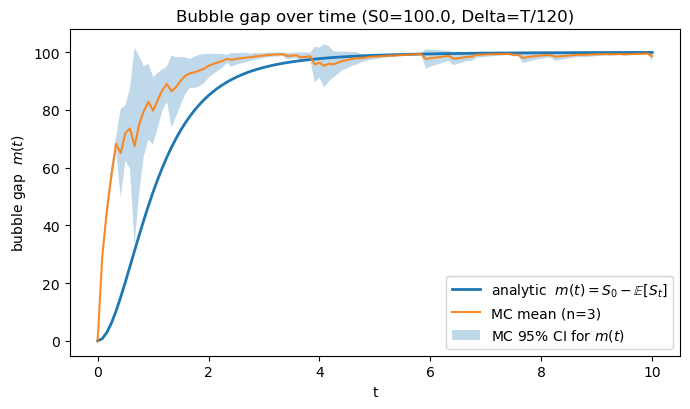

t= 0.5  analytic m(t)=20.415457   MC m(t)=72.006398  ±1.96SE≈9.609367
t= 1.0  analytic m(t)=51.567098   MC m(t)=79.750663  ±1.96SE≈11.693486
t= 2.0  analytic m(t)=85.024964   MC m(t)=95.302939  ±1.96SE≈4.119444
t= 5.0  analytic m(t)=98.932029   MC m(t)=98.547405  ±1.96SE≈1.006458
t=10.0  analytic m(t)=99.936055   MC m(t)=98.674000  ±1.96SE≈1.884236


In [11]:
def E_S_analytic(t, S0):
    x0 = np.log1p(S0)
    return np.exp(x0 * (2.0*np.exp(-t/2.0) - np.exp(-t))) - 1.0

def m_analytic(t, S0):
    return S0 - E_S_analytic(t, S0)

m_true = m_analytic(times, S0)
S_mean = Spaths.mean(axis=0)
S_se   = Spaths.std(axis=0, ddof=1) / np.sqrt(Spaths.shape[0])  
m_mc   = S0 - S_mean
m_lo   = S0 - (S_mean + 1.96*S_se)   
m_hi   = S0 - (S_mean - 1.96*S_se)
assert np.all(m_true >= -1e-10) and np.all(m_true <= S0 + 1e-10)

plt.figure(figsize=(7,4.2))
plt.plot(times, m_true, label="analytic  $m(t)=S_0-\\mathbb{E}[S_t]$", linewidth=2)
plt.plot(times, m_mc,   label=f"MC mean (n={n_paths})", linewidth=1.5, alpha=0.9)
plt.fill_between(times, m_lo, m_hi, alpha=0.28, label="MC 95% CI for $m(t)$")
plt.xlabel("t"); plt.ylabel("bubble gap  $m(t)$")
plt.title(f"Bubble gap over time (S0={S0}, Delta=T/{n_steps})")
plt.legend()
plt.tight_layout()
plt.show()

for t_q in [0.5, 1, 2, 5, 10]:
    j = np.searchsorted(times, t_q)
    print(f"t={times[j]:>4.1f}  analytic m(t)={m_true[j]:.6f}   "
          f"MC m(t)={m_mc[j]:.6f}  ±1.96SE≈{1.96*S_se[j]:.6f}")

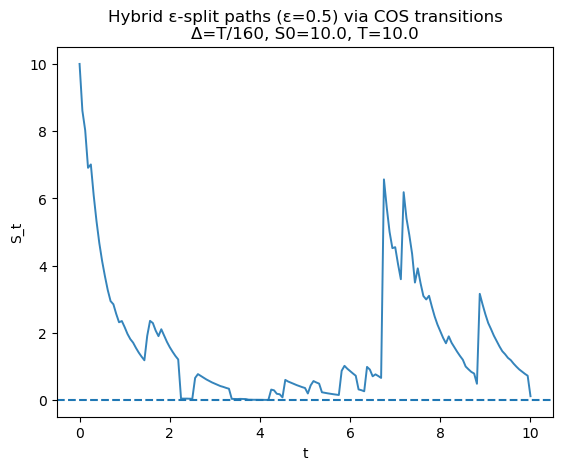

S_T stats: mean=0.123448


In [12]:
### epsilon split ###
def _build_increment_grid(xcur, dt, N=N_terms, L=L_trunc):
    x_next_grid, fX = cos_step_pdf(dt, xcur, N=N, L=L)  
    y_grid = x_next_grid - xcur                          
    w = np.diff(y_grid)
    avg = 0.5*(fX[:-1] + fX[1:])
    cdf = np.concatenate([[0.0], np.cumsum(avg * w)])
    total = cdf[-1]
    if total <= 0:
        idx = np.argmin(np.abs(y_grid))
        fX = np.zeros_like(fX); fX[idx] = 1.0
        w = np.diff(y_grid)
        avg = 0.5*(fX[:-1] + fX[1:])
        cdf = np.concatenate([[0.0], np.cumsum(avg * w)])
        total = cdf[-1] if cdf[-1] > 0 else 1.0
    cdf /= total
    return y_grid, fX, cdf

def _interp_inv_cdf(y_grid, cdf, u):
    cdf_eps = np.maximum.accumulate(np.minimum(cdf, 1.0 - 1e-14))
    return np.interp(u, cdf_eps, y_grid)

def _cdf_at(y_grid, cdf, y0):
    return float(np.interp(y0, y_grid, cdf, left=0.0, right=1.0))

def _sample_increment_eps(y_grid, fY, cdf, eps, rng):
    cdf_left = _cdf_at(y_grid, cdf, -eps)
    cdf_right = _cdf_at(y_grid, cdf, eps)
    p_small = max(cdf_right - cdf_left, 0.0)      # P(|Y|<=eps)
    p_left  = max(cdf_left, 0.0)                  # P(Y < -eps)
    p_right = max(1.0 - cdf_right, 0.0)           # P(Y >  eps)
    p_big = p_left + p_right

    u = rng.random()
    if p_big > 1e-12 and u < p_big:
        if rng.random() < (p_left / p_big if p_big > 0 else 0.0):
            u_tail = rng.random() * p_left
            y = _interp_inv_cdf(y_grid, cdf, u_tail)
        else:
            u_tail = cdf_right + rng.random() * p_right
            y = _interp_inv_cdf(y_grid, cdf, u_tail)
        return y, True
    else:
        mass = max(p_small, 1e-15)
        u_block = cdf_left + rng.random() * mass
        y = _interp_inv_cdf(y_grid, cdf, u_block)
        return y, False

def simulate_paths_S_hybrid(S0, T, n_steps, n_paths, eps=0.25, N=N_terms, L=L_trunc, seed=0):
    rng   = np.random.default_rng(seed)
    dt    = T / n_steps
    times = np.linspace(0.0, T, n_steps+1)
    X     = np.empty((n_paths, n_steps+1))
    X[:, 0] = np.log1p(S0)
    jumps = [[] for _ in range(n_paths)]
    
    for k in range(n_steps):
        t_left = times[k]
        for i in range(n_paths):
            xcur = X[i, k]
            y_grid, fY_like, cdf = _build_increment_grid(xcur, dt, N=N, L=L)
            dy, is_big = _sample_increment_eps(y_grid, fY_like, cdf, eps, rng)
            xnew = xcur + dy
            if xnew < 0.0:
                xnew = 0.0
            X[i, k+1] = xnew
            if is_big:
                tau = t_left + rng.random() * dt
                jumps[i].append((tau, float(dy)))
    return times, np.expm1(X), jumps

if __name__ == "__main__":
    S0_demo, T_demo = 10.0, 10.0
    n_steps_demo, n_paths_demo = 160, 1
    eps_demo = 0.5  
    times_h, Spaths_h, jumps_h = simulate_paths_S_hybrid(
        S0_demo, T_demo, n_steps_demo, n_paths_demo,
        eps=eps_demo, N=N_terms, L=L_trunc, seed=2025
    )

    plt.figure()
    for i in range(Spaths_h.shape[0]):
        plt.plot(times_h, Spaths_h[i], linewidth=1.4, alpha=0.9)
    plt.title(f"Hybrid ε-split paths (ε={eps_demo}) via COS transitions\nΔ=T/{n_steps_demo}, S0={S0_demo}, T={T_demo}")
    plt.xlabel("t"); plt.ylabel("S_t"); plt.axhline(0.0, linestyle="--")
    plt.show()
    ST = Spaths_h[:, -1]
    print(f"S_T stats: mean={float(np.mean(ST)):.6f}")

In [13]:
def plot_vertical_jumps_only(times, Spaths, jumps, path_idx=0, show_points=True):
    t0 = times[0]
    dt = times[1] - times[0]
    S = Spaths[path_idx]
    J = sorted(jumps[path_idx], key=lambda z: z[0])
    
    plt.figure()
    for (tau, _dy) in J:
        k = min(int((tau - t0) // dt), len(times) - 2)
        S_pre  = float(S[k])     
        S_post = float(S[k+1])   
        y1, y2 = (S_pre, S_post) if S_post >= S_pre else (S_post, S_pre)
        plt.vlines(tau, y1, y2, linewidth=2)
        if show_points:
            plt.scatter([tau, tau], [S_pre, S_post], s=24, zorder=3)

    plt.axhline(0.0, ls="--", lw=1, color = 'peru')
    plt.xlim(times[0], times[-1])
    plt.xlabel("t"); plt.ylabel("S_t")
    plt.title("Explicit big jumps only (vertical segments)")
    plt.show()

def plot_nonjump_segments_only(times, Spaths, jumps, path_idx=0, show_points=False, **line_kwargs):
    t = np.asarray(times)
    S = np.asarray(Spaths[path_idx], dtype=float)
    n = len(t)

    jump_steps = np.zeros(n-1, dtype=bool)
    if jumps and len(jumps[path_idx]) > 0:
        t0 = t[0]
        dt = t[1] - t[0]
        for (tau, _dy) in jumps[path_idx]:
            k = int((tau - t0) // dt)
            if 0 <= k < n-1:
                jump_steps[k] = True

    if "linewidth" not in line_kwargs: line_kwargs["linewidth"] = 1.6
    if "alpha" not in line_kwargs:     line_kwargs["alpha"]     = 0.95

    plt.figure()
    for k in range(n-1):
        if not jump_steps[k]:
            plt.plot(t[k:k+2], S[k:k+2], **line_kwargs)
            if show_points:
                plt.scatter([t[k], t[k+1]], [S[k], S[k+1]], s=18, zorder=3)
    plt.axhline(0.0, ls="--", lw=1, color ='peru')
    plt.xlim(t[0], t[-1])
    plt.xlabel("t"); plt.ylabel("S_t")
    plt.title("Non-jump segments only (big jumps omitted)")
    plt.show()

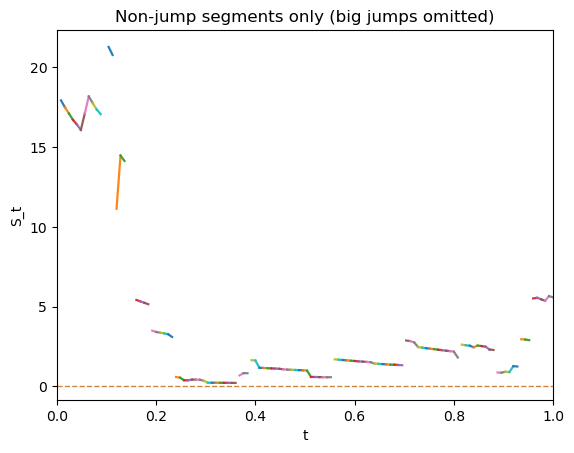

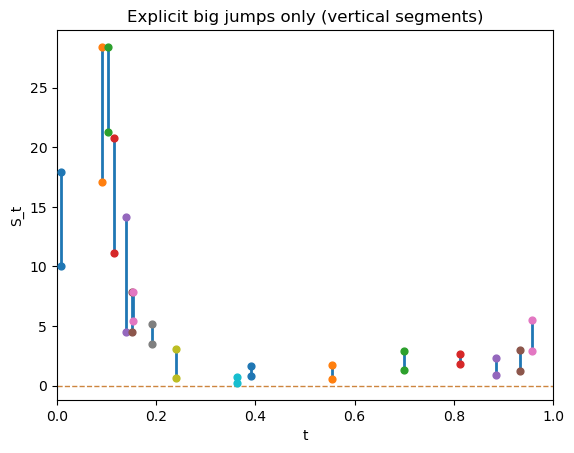

In [14]:
times_h, Spaths_h, jumps_h = simulate_paths_S_hybrid(S0=10, T=1, n_steps=125,
                                                     n_paths=1, eps=0.25, seed=2019)

plot_nonjump_segments_only(times_h, Spaths_h, jumps_h, path_idx=0, show_points=False)
plot_vertical_jumps_only(times_h, Spaths_h, jumps_h, path_idx=0)

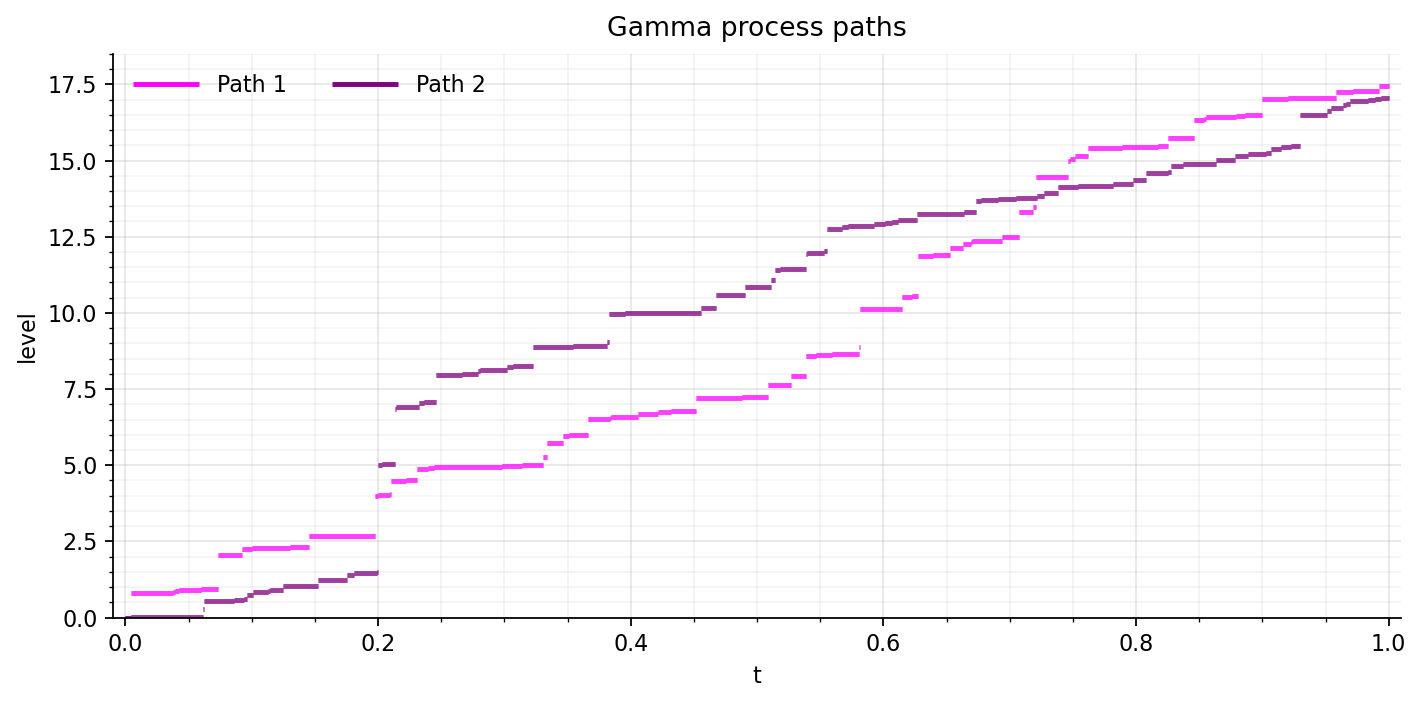

In [15]:
def gamma_process(N=2000, nsim=2, alpha=20.0, scale=1.0, T=1.0, seed=None):
    rng = np.random.default_rng(seed)
    dt = T / N
    dX = rng.gamma(shape=alpha * dt, scale=scale, size=(nsim, N))
    X = np.cumsum(dX, axis=1)
    X = np.concatenate([np.zeros((nsim, 1)), X], axis=1) 
    t = np.linspace(0.0, T, N + 1)
    return t, X

def axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, which="major", alpha=0.30)
    ax.grid(True, which="minor", alpha=0.15)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.margins(x=0.01, y=0.05)

def plot_stairs(t, X, title="Gamma process paths"):
    fig, ax = plt.subplots(figsize=(9, 4.5), dpi=160)
    for i in range(X.shape[0]):
        ax.hlines(X[i, :-1], t[:-1], t[1:], linewidth=2.2, label=f"Path {i+1}", color=palette[i % len(palette)])
    ax.set_ylim(0, float(X.max()) * 1.06)
    ax.set_xlabel("t")
    ax.set_ylabel("level")
    ax.set_title(title, pad=8)
    ax.legend(loc="upper left", frameon=False, ncol=min(X.shape[0], 3), handlelength=3)
    axes(ax)
    fig.tight_layout()
    return fig

### plot ###
palette = ["magenta", "purple"] 
t, X = gamma_process(N=2000, nsim=2, alpha=20.0, scale=1.0, T=1.0, seed=7)
plot_stairs(t, X)
plt.show()

E_Q[S_T]_hat = 55.797,   m_hat = 44.203 (S0 - E_hat)


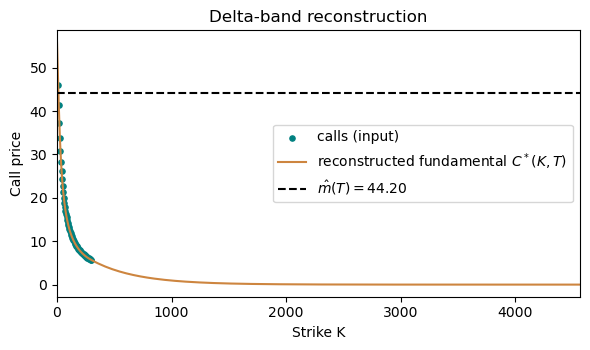

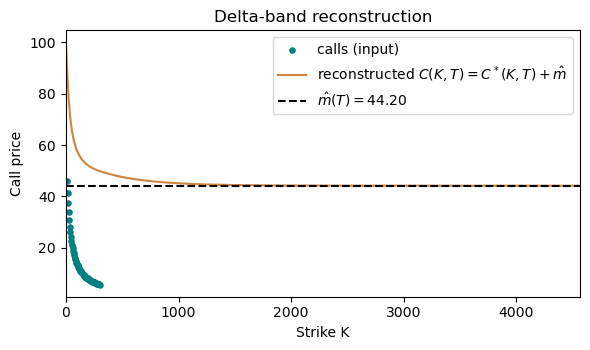

In [16]:
### Black-Scholes ###
def _N(x):
    x = np.asarray(x)
    return 0.5*(1.0 + np.vectorize(math.erf)(x/np.sqrt(2.0)))

def bs_call_delta(S0, K, T, r, d, sigma):
    if T <= 0 or sigma <= 0:
        return float(np.exp(-d*T) * (1.0 if S0>K else (0.0 if S0<K else 0.5)))
    srt = sigma*np.sqrt(T)
    d1 = (np.log(S0/K) + (r - d + 0.5*sigma*sigma)*T)/srt
    return float(np.exp(-d*T)*_N(d1))

def implied_vol_call(price, S0, K, T, r, d, tol=1e-8, maxit=120):
    def _bs_price(S0, K, T, r, d, sigma):
        if T <= 0 or sigma <= 0: return float(max(S0 - K, 0.0))
        srt = sigma*np.sqrt(T)
        d1 = (np.log(S0/K) + (r - d + 0.5*sigma*sigma)*T)/srt
        d2 = d1 - srt
        return float(S0*np.exp(-d*T)*_N(d1) - K*np.exp(-r*T)*_N(d2))
    intrinsic = max(S0 - K, 0.0)
    p = min(max(price, intrinsic), S0)
    lo, hi = 1e-8, 5.0
    f_lo = _bs_price(S0, K, T, r, d, lo) - p
    f_hi = _bs_price(S0, K, T, r, d, hi) - p
    if f_lo*f_hi <= 0:
        for _ in range(maxit):
            mid = 0.5*(lo+hi)
            f_mid = _bs_price(S0, K, T, r, d, mid) - p
            if abs(f_mid) < tol or (hi-lo) < 1e-8: return max(mid, 1e-8)
            if f_lo*f_mid <= 0: hi, f_hi = mid, f_mid
            else:               lo, f_lo = mid, f_mid
    sigma = 0.4
    for _ in range(maxit):
        diff = _bs_price(S0, K, T, r, d, sigma) - p
        if abs(diff) < tol: return max(sigma, 1e-8)
        h = 1e-4
        up = _bs_price(S0, K, T, r, d, sigma+h)
        dn = _bs_price(S0, K, T, r, d, sigma-h)
        vega = (up - dn)/(2*h)
        if vega <= 1e-10: break
        sigma = max(1e-8, sigma - diff/vega)
    return max(sigma, 1e-8)
    
def monotone_decreasing_projection(q):
    q = np.clip(np.asarray(q,float), 0.0, 1.0)
    out = np.empty_like(q); m = 1.0
    for i, val in enumerate(q):
        m = min(m, val); out[i] = m
    return out

def isotonic_increasing(y):
    y = np.asarray(y, float).copy(); n = len(y)
    lvl = y.copy(); w = np.ones(n); i = 0
    while i < n-1:
        if lvl[i] > lvl[i+1]:
            tot = lvl[i]*w[i] + lvl[i+1]*w[i+1]
            w[i+1] += w[i]; lvl[i+1] = tot / w[i+1]
            j = i
            while j > 0 and lvl[j-1] > lvl[j]:
                tot = lvl[j-1]*w[j-1] + lvl[j]*w[j]
                w[j] += w[j-1]; lvl[j] = tot / w[j]; j -= 1
            lvl = np.delete(lvl, i); w = np.delete(w, i); n -= 1; i = max(j, 0)
        else:
            i += 1
    return np.repeat(lvl, w.astype(int))

def convex_decreasing_fit_on_band(K, C):
    K = np.asarray(K, float); C = np.asarray(C, float)
    idx = np.argsort(K); K, C = K[idx], C[idx]
    dK = np.diff(K); s = np.diff(C)/dK
    s_iso = isotonic_increasing(s)
    s_iso = np.minimum(s_iso, 0.0)
    cum = np.concatenate(([0.0], np.cumsum(s_iso*dK)))
    y1  = np.mean(C - cum)
    C_fit = np.maximum(y1 + cum, 0.0)
    dC = np.empty_like(C_fit)
    dC[0]  = (C_fit[1]-C_fit[0])/(K[1]-K[0])
    dC[-1] = (C_fit[-1]-C_fit[-2])/(K[-1]-K[-2])
    dC[1:-1] = (C_fit[2:]-C_fit[:-2])/(K[2:]-K[:-2])
    return K, C_fit, dC

### delta-band estimator ###
def delta_band_from_calls(K, C, S0, T, r=0.0, d=0.0,
                          band=(0.45,0.55), left_mode="linear", left_alpha=None):
    K = np.asarray(K, float); C = np.asarray(C, float)
    Ctilde = C * np.exp(r*T); F0T = S0 * np.exp((r - d)*T)
    ivs  = [implied_vol_call(c, S0, k, T, r, d) for k,c in zip(K,C)]
    dels = [bs_call_delta(S0, k, T, r, d, s)   for k,s in zip(K,ivs)]
    ivs, dels = np.array(ivs), np.array(dels)
    msk = (dels >= band[0]) & (dels <= band[1])
    if msk.sum() < 3: raise ValueError("Not enough quotes in chosen delta band")
    Kb, Cb = K[msk], Ctilde[msk]
    K_mid, C_fit_mid, dC_mid = convex_decreasing_fit_on_band(Kb, Cb)
    q_mid = monotone_decreasing_projection(-dC_mid)
    K0, q0 = K_mid[0], float(np.clip(q_mid[0], 0.0, 1.0))
    if left_alpha is not None:
        gamma = left_alpha/(1.0-left_alpha) if left_alpha < 1 else 1e6
        K_left = np.linspace(0.0, K0, 256)
        q_left = 1.0 - (1.0-q0)*(K_left/K0)**gamma
        E_left = float(np.trapz(q_left, K_left))
    else:
        if left_mode == "min":
            K_left = np.linspace(0.0, K0, 64); q_left = np.full_like(K_left, q0); E_left = K0*q0
        elif left_mode == "max":
            K_left = np.linspace(0.0, K0, 64); q_left = np.ones_like(K_left);     E_left = K0
        else:
            K_left = np.linspace(0.0, K0, 64); q_left = np.linspace(1.0, q0, 64); E_left = 0.5*(1+q0)*K0

    KN, CN = K_mid[-1], float(C_fit_mid[-1])
    qN = max(min(q_mid[-1], 1.0), 1e-8)
    lam = qN / max(CN, 1e-12)
    K_right = np.linspace(KN, KN + 20.0/lam, 256)
    q_right = qN * np.exp(-lam*(K_right-KN))
    E_mid   = float(np.trapz(q_mid, K_mid))
    E_right = float(CN)  # exact integral under our match
    E_hat   = float(E_left + E_mid + E_right)
    m_hat   = float(F0T - E_hat)

    K_all  = np.concatenate([K_left[:-1], K_mid, K_right])
    q_all  = np.concatenate([q_left[:-1], q_mid, q_right])
    idx = np.argsort(K_all); K_all, q_all = K_all[idx], q_all[idx]
    tail = np.zeros_like(K_all); acc=0.0
    for i in range(len(K_all)-2, -1, -1):
        dK = K_all[i+1] - K_all[i]
        acc += 0.5*(q_all[i] + q_all[i+1])*dK
        tail[i] = acc
    Cstar = tail
    if K_all[0] > 0: K_all = np.insert(K_all, 0, 0.0); Cstar = np.insert(Cstar, 0, E_hat)
    Cobs = Cstar + m_hat
    return {"F0T":F0T, "E_hat":E_hat, "m_hat":m_hat, "K":K, "C":C,
            "curves":{"K_all":K_all, "Cstar":Cstar, "Cobs":Cobs}}

def plot_call_and_tail_delta_band(est, show="fundamental", title="Delta-band reconstruction"):
    K, C = est["K"], est["C"]
    K_all  = est["curves"]["K_all"]
    Cstar  = est["curves"]["Cstar"]        
    m_hat  = est["m_hat"]
    
    if show == "observed":
        yline = Cstar + m_hat             
        label = r"reconstructed $C(K,T)=C^*(K,T)+\hat{m}$"
    else:  # "fundamental"
        yline = Cstar
        label = r"reconstructed fundamental $C^*(K,T)$"
        
    ### focus on the useful range ###
    j = np.argmax(Cstar < 1e-4) if np.any(Cstar < 1e-4) else len(Cstar)-1
    xmax = K_all[max(10, j)]
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3.6))
    plt.scatter(K, C, s=14, label="calls (input)", color = "teal")
    plt.plot(K_all, yline, label=label, color = "peru")
    plt.axhline(m_hat, ls="--", label=r"$\hat{m}(T)=$"f"{m_hat:.2f}", color = "black")
    plt.xlim(0, xmax)
    plt.xlabel("Strike K"); plt.ylabel("Call price")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

def sim_cev_paths(N, M, T, rng, sigma=0.16, beta=1.5, S0=100.0):
    assert beta > 1.0
    dt = T / M; sdt = np.sqrt(dt)
    Z = rng.standard_normal((N, M))
    a = (beta-1.0)*sigma
    b = 0.5*(beta-1.0)*beta*sigma**2
    Y = np.full(N, S0**(-(beta-1.0)))
    eps = 1e-12
    for k in range(M):
        dW = sdt * Z[:, k]
        Y = Y - a*dW + b*dt/np.maximum(Y, eps)
        Y = np.maximum(Y, eps)
    S = np.power(Y, -1.0/(beta-1.0))
    return np.minimum(S, 1e12)

S0, T = 100.0, 1.0
rng = np.random.default_rng(2)

### models ###
ST = sim_cev_paths(N=30000, M=1500, T=T, rng=rng, sigma=0.16, beta=1.5, S0=S0)

### price calls on a grid from the MC ST r=d=0 ###
K = np.linspace(0.1*S0, 3.0*S0, 60)
C = np.maximum(ST[:,None] - K[None,:], 0.0).mean(axis=0)

est = delta_band_from_calls(K, C, S0=S0, T=T, r=0.0, d=0.0,
                            band=(0,1), left_mode="linear")

### plot ###
print(f"E_Q[S_T]_hat = {est['E_hat']:.3f},   m_hat = {est['m_hat']:.3f} (S0 - E_hat)")
plot_call_and_tail_delta_band(est, title="Delta-band reconstruction")
plot_call_and_tail_delta_band(est, show="observed", title="Delta-band reconstruction")

In [17]:
def delta_band_quality_report(est, K_market, C_market):
    K_all  = est["curves"]["K_all"].astype(float)
    Cstar  = est["curves"]["Cstar"].astype(float)
    m_hat  = est["m_hat"]
    E_hat  = est["E_hat"]

    ### drop duplicates in K_all ###
    mask = np.isfinite(K_all) & np.isfinite(Cstar)
    K_all, Cstar = K_all[mask], Cstar[mask]
    keep = np.r_[True, np.diff(K_all) > 1e-12]
    K_all, Cstar = K_all[keep], Cstar[keep]

    ### shape checks ###
    dK = np.diff(K_all)
    d1 = np.diff(Cstar)/dK
    d2 = np.diff(d1)/dK[:-1]
    dec_ok  = d1.max() <= 1e-9
    conv_ok = d2.min() >= -1e-9

    ### q(K) and integral ###
    q_num = -np.gradient(Cstar, K_all, edge_order=2)
    q_ok  = (q_num.min() >= -1e-8) and (q_num.max() <= 1+1e-8)
    E_check = np.trapz(q_num, K_all)
    mass_err = abs(E_check - E_hat)

    ### plot output ###
    return {
        "decreasing_ok": dec_ok,
        "convex_ok": conv_ok,
        "q_bounds_ok": q_ok,
        "mass_error": mass_err,
    }

rep = delta_band_quality_report(est, est["K"], est["C"])
print(rep)

{'decreasing_ok': True, 'convex_ok': True, 'q_bounds_ok': True, 'mass_error': 0.0756042849356362}


In [18]:
def clean_cboe(raw_path, out_path,
                       S0_force=None, r=0.045, d=0.0):
    txt = Path(raw_path).read_text(errors="replace").splitlines()
    mS0 = re.search(r"Last:\s*([0-9.]+)", txt[0]) if txt else None
    S0  = float(mS0.group(1)) if mS0 else np.nan
    mDT = re.search(r"Date:\s*([^,]+)", txt[1]) if len(txt)>1 else None
    qdate = pd.to_datetime(mDT.group(1), errors="coerce").normalize() if mDT else pd.Timestamp.today().normalize()
    hdr = next(i for i, l in enumerate(txt) if l.lower().startswith("expiration date"))

    rows = []
    for line in txt[hdr+1:]:
        p = [s.strip() for s in line.split(",")]
        if len(p) < 22: 
            continue
        exp = pd.to_datetime(p[0], errors="coerce")
        call_sym = p[1]
        bid = pd.to_numeric(p[4], errors="coerce")
        ask = pd.to_numeric(p[5], errors="coerce")
        iv  = pd.to_numeric(p[7], errors="coerce")
        delta = pd.to_numeric(p[8], errors="coerce")
        strike_disp = pd.to_numeric(p[11], errors="coerce")

        m = re.search(r"[CP](\d{8})$", call_sym or "")
        if m:
            code = m.group(1)
            K = int(code[:5]) + int(code[5:])/1000.0
        else:
            K = float(strike_disp) if pd.notna(strike_disp) else np.nan
            if pd.notna(K) and K <= 20:  # display quirk
                K *= 100.0
        if not (pd.notna(exp) and pd.notna(K) and pd.notna(bid) and pd.notna(ask) and bid>0 and ask>=bid):
            continue
        rows.append((exp, K, 0.5*(bid+ask), bid, ask, delta, iv))
    df = pd.DataFrame(rows, columns=["exp","K","C","bid","ask","delta_raw","iv"])
    if df.empty:
        raise RuntimeError("No firm-call quotes found in the file.")

    exp_chosen = df["exp"].value_counts().idxmax()
    sub = df[df["exp"]==exp_chosen].copy()
    sub["rel_spread"] = (sub["ask"] - sub["bid"]) / sub["C"].clip(lower=1e-9)
    sub = sub.sort_values(["K","rel_spread"]).groupby("K", as_index=False).first().sort_values("K")

    T = ((pd.to_datetime(exp_chosen).normalize() - qdate).days/365.0)
    if S0_force is not None:
        S0 = float(S0_force)
    elif not np.isfinite(S0):
        S0 = float(sub.sort_values("C", ascending=False)["K"].head(10).median())

    out = pd.DataFrame({
        "exp_dt": [pd.to_datetime(exp_chosen).date()]*len(sub),
        "K": sub["K"].to_numpy(),
        "C": sub["C"].to_numpy(),
        "T": [float(max(T,0.0))]*len(sub),
        "S0": [S0]*len(sub),
        "r": [r]*len(sub),
        "d": [d]*len(sub),
        "delta_raw": sub["delta_raw"].to_numpy(),
        "iv": sub["iv"].to_numpy(),
    })
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    out.to_csv(out_path, index=False)
    return out

### clean file ###
clean_cboe("NVDA DEC 2027 QUOTES.csv", "NVDA DEC 2027 CLEAN.csv", S0_force=169.84, r=0.045, d=0.0)

,exp_dt,K,C,T,S0,r,d,delta_raw,iv
0,2027-12-17,5.0,165.800,2.265753,169.84,0.045,0.0,1.0000,0.0000
1,2027-12-17,10.0,161.350,2.265753,169.84,0.045,0.0,1.0000,0.0000
2,2027-12-17,15.0,156.575,2.265753,169.84,0.045,0.0,1.0000,0.0000
3,2027-12-17,20.0,152.900,2.265753,169.84,0.045,0.0,1.0000,0.0000
4,2027-12-17,25.0,148.150,2.265753,169.84,0.045,0.0,1.0000,0.0000
5,2027-12-17,30.0,143.500,2.265753,169.84,0.045,0.0,1.0000,0.0000
6,2027-12-17,35.0,138.400,2.265753,169.84,0.045,0.0,0.9996,0.0000
7,2027-12-17,40.0,134.575,2.265753,169.84,0.045,0.0,0.9965,0.0000
8,2027-12-17,45.0,130.625,2.265753,169.84,0.045,0.0,0.9928,0.0000
9,2027-12-17,50.0,126.575,2.265753,169.84,0.045,0.0,0.9886,0.4365


E_Q[S_T]_hat = 161.1472   |   m_hat = 16.6855


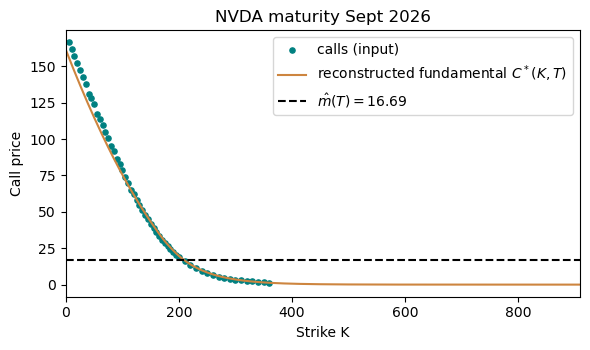

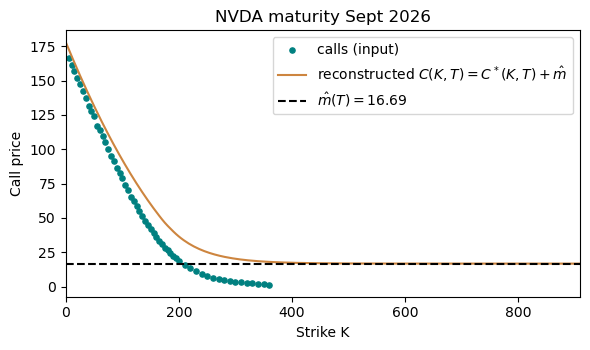

In [19]:
OUT_CLEAN = "NVDA SEPT 2026 CLEAN.csv"

tidy = pd.read_csv(OUT_CLEAN)
K  = tidy["K"].to_numpy()
C  = tidy["C"].to_numpy()
S0 = float(tidy["S0"].iloc[0])
T  = float(tidy["T"].iloc[0])
r  = float(tidy["r"].iloc[0])
d  = float(tidy["d"].iloc[0])
est = delta_band_from_calls(K, C, S0=S0, T=T, r=r, d=d,
                            band=(0.5, 0.7), left_mode="linear")

print(f"E_Q[S_T]_hat = {est['E_hat']:.4f}   |   m_hat = {est['m_hat']:.4f}")
plot_call_and_tail_delta_band(est, title="NVDA maturity Sept 2026")
plot_call_and_tail_delta_band(est, show="observed", title="NVDA maturity Sept 2026")

                        file         T  band_lo  band_hi       E_hat  \
0   NVDA SEPT 2026 CLEAN.csv  1.021918      0.4     0.55  155.205810   
1   NVDA SEPT 2026 CLEAN.csv  1.021918      0.5     0.70  161.147155   
2   NVDA SEPT 2026 CLEAN.csv  1.021918      0.5     0.70  161.147155   
3   NVDA SEPT 2026 CLEAN.csv  1.021918      0.5     0.90  168.133076   
4    NVDA DEC 2026 CLEAN.csv  1.271233      0.4     0.55  177.890750   
5    NVDA DEC 2026 CLEAN.csv  1.271233      0.5     0.70  164.496537   
6    NVDA DEC 2026 CLEAN.csv  1.271233      0.5     0.70  164.496537   
7    NVDA DEC 2026 CLEAN.csv  1.271233      0.5     0.90  171.066559   
8    NVDA JAN 2027 CLEAN.csv  1.347945      0.4     0.55  160.824041   
9    NVDA JAN 2027 CLEAN.csv  1.347945      0.5     0.70  166.941924   
10   NVDA JAN 2027 CLEAN.csv  1.347945      0.5     0.70  166.941924   
11   NVDA JAN 2027 CLEAN.csv  1.347945      0.5     0.90  177.299173   
12  NVDA JUNE 2027 CLEAN.csv  1.767123      0.4     0.55  165.85

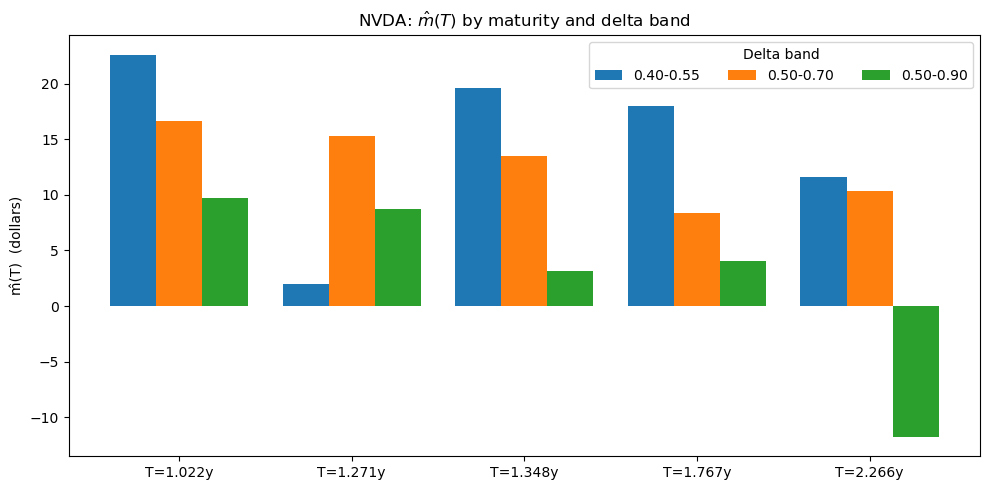

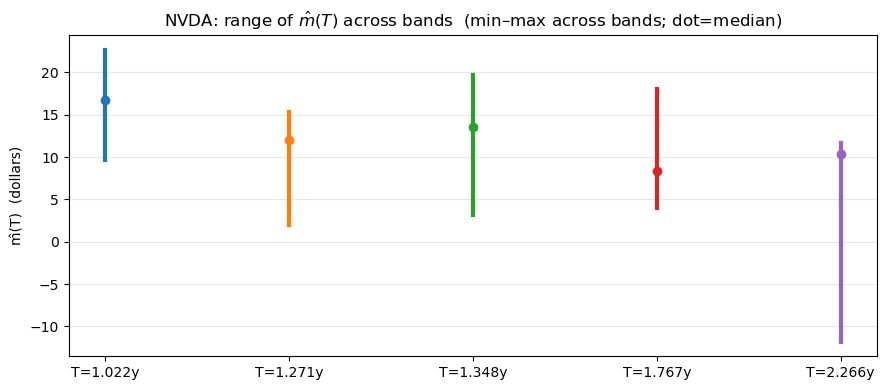

In [20]:
### Plot of m_hat across diff maturities and delta bands ###
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def _infer_deltas_if_needed(df, S0, T, r, d):
    if "delta_raw" in df.columns and pd.notna(df["delta_raw"]).any():
        return df["delta_raw"].to_numpy()
    # infer from IVs + BS if needed
    ivs = np.array([implied_vol_call(c, S0, k, T, r, d) for k,c in zip(df["K"], df["C"])])
    dels = np.array([bs_call_delta(S0, k, T, r, d, s) for k,s in zip(df["K"], ivs)])
    return dels

def _run_one_file(path, bands):
    df = pd.read_csv(path)
    S0 = float(df["S0"].iloc[0]); T = float(df["T"].iloc[0])
    r  = float(df["r"].iloc[0]);  d = float(df["d"].iloc[0])
    K  = df["K"].to_numpy();      C = df["C"].to_numpy()
    dels = _infer_deltas_if_needed(df, S0, T, r, d)
    F0T = S0*np.exp((r-d)*T)
    rows = []
    for (lo,hi) in bands:
        m = (dels >= lo) & (dels <= hi) & np.isfinite(C)
        if m.sum() < 6:
            m = (dels >= 0.35) & (dels <= 0.65) & np.isfinite(C)
        Km, Cm = (K[m], C[m]) if m.sum() >= 3 else (K, C)
        est = delta_band_from_calls(Km, Cm, S0=S0, T=T, r=r, d=d,
                                    band=(lo,hi), left_mode="linear")
        rows.append({
            "file": Path(path).name,
            "T": T, "S0": S0, "r": r, "d": d,
            "band_lo": lo, "band_hi": hi,
            "E_hat": est["E_hat"], "m_hat": est["m_hat"], "F0T": F0T,
            "m_pct_forward": 100.0*est["m_hat"]/F0T
        })
    return pd.DataFrame(rows)

def build_mhat_panel(files, bands):
    parts = [ _run_one_file(p, bands) for p in files ]
    panel = pd.concat(parts, ignore_index=True)
    # order by maturity
    panel = panel.sort_values("T").reset_index(drop=True)
    return panel

def plot_mhat_grouped(panel, title="m̂(T) by maturity and delta band"):
    Tvals = panel["T"].round(4).unique()
    bands = panel[["band_lo","band_hi"]].drop_duplicates().to_numpy().tolist()
    band_labels = [f"{lo:.2f}-{hi:.2f}" for lo,hi in bands]
    bw = 0.8/len(bands)
    xs = np.arange(len(Tvals))
    plt.figure(figsize=(10,5))
    for j,(lo,hi) in enumerate(bands):
        y = []
        for T in Tvals:
            row = panel[(panel["T"].round(4)==T) & (panel["band_lo"]==lo) & (panel["band_hi"]==hi)]
            y.append(float(row["m_hat"].iloc[0]))
        plt.bar(xs + j*bw - 0.4 + bw/2, y, width=bw, label=f"{lo:.2f}-{hi:.2f}")
    plt.xticks(xs, [f"T={t:.3f}y" for t in Tvals], rotation=0)
    plt.ylabel("m̂(T)  (dollars)")
    plt.title(title)
    plt.legend(title="Delta band", ncol=min(4,len(bands)))
    plt.tight_layout()
    plt.show()

def plot_mhat_band_interval(panel, title="Band range for m̂(T)"):
    Tvals = panel["T"].round(4).unique()
    xs = np.arange(len(Tvals))
    mins, meds, maxs = [], [], []
    for T in Tvals:
        vals = panel[panel["T"].round(4)==T]["m_hat"].to_numpy()
        mins.append(np.min(vals)); maxs.append(np.max(vals)); meds.append(np.median(vals))
    plt.figure(figsize=(9,4))
    for i,(mn,md,mx) in enumerate(zip(mins,meds,maxs)):
        plt.plot([i,i],[mn,mx], lw=3)         
        plt.scatter([i],[md], zorder=3)       
    plt.xticks(xs, [f"T={t:.3f}y" for t in Tvals])
    plt.ylabel("m̂(T)  (dollars)")
    plt.title(title + "  (min–max across bands; dot=median)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()

### input clean files ###
files = [
    "NVDA SEPT 2026 CLEAN.csv",
    "NVDA DEC 2026 CLEAN.csv",
    "NVDA JAN 2027 CLEAN.csv",
    "NVDA JUNE 2027 CLEAN.csv",
    "NVDA DEC 2027 CLEAN.csv",
]

bands = [(0.4,0.55),(0.50,0.70),(0.50,0.70),(0.500,0.90)]
panel = build_mhat_panel(files, bands)
### plots ###
print(panel[["file","T","band_lo","band_hi","E_hat","m_hat","m_pct_forward"]])
plot_mhat_grouped(panel, title=r"NVDA: $\hat{m}(T)$ by maturity and delta band")
plot_mhat_band_interval(panel, title=r"NVDA: range of $\hat{m}(T)$ across bands")